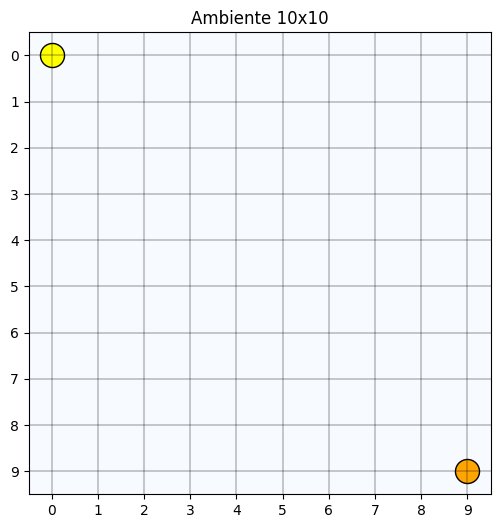


=== Estatísticas ===
Recompensa média por passo:
  média = 0.2301225490397025
  desvio padrão = 0.2831066600063822

Passos até ao objetivo:
  média = 642.6666666666666
  desvio padrão = 337.75892125729104

Tempo de execução:
  média = 0.00036814212799072263
  desvio padrão = 0.0013036747589616209


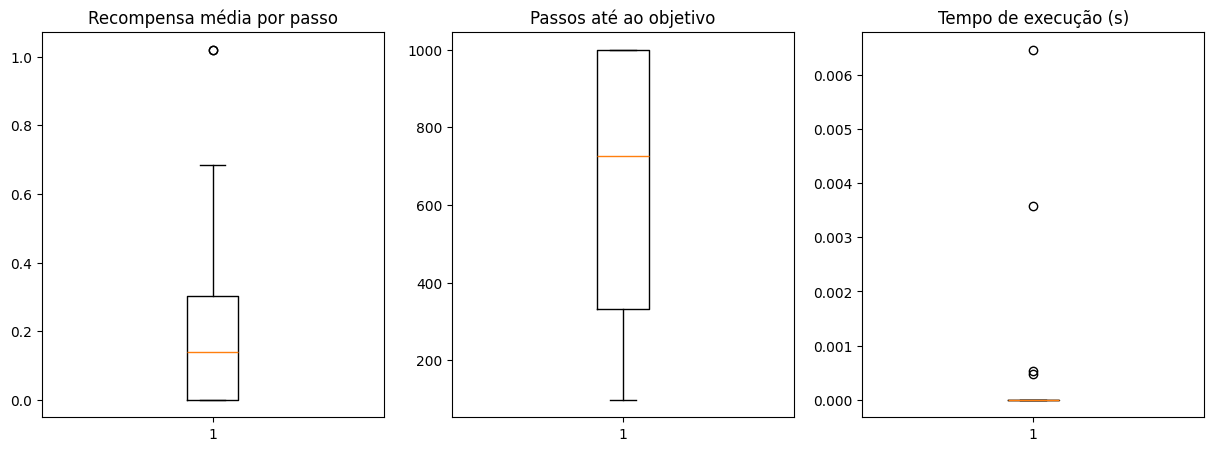

In [ ]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

GRID_ROWS = 10
GRID_COLS = 10

START_STATE = 1
GOAL_STATE = 100

ACTIONS = ["up", "down", "left", "right"]
ACTION_DELTAS = {
    "up": (-1, 0),
    "down": (1, 0),
    "left": (0, -1),
    "right": (0, 1)
}

# Converte número de estado para (linha, coluna)
def state_to_coords(state):
    row = (state - 1) // GRID_COLS
    col = (state - 1) % GRID_COLS
    return row, col

# Converte (linha, coluna) para número de estado
def coords_to_state(row, col):
    return row * GRID_COLS + col + 1

# Movimentos no ambiente
def transition(state, action):
    row, col = state_to_coords(state)
    dr, dc = ACTION_DELTAS[action]

    new_row = row + dr
    new_col = col + dc

    # fora da grelha -> fica no mesmo
    if not (0 <= new_row < GRID_ROWS and 0 <= new_col < GRID_COLS):
        return state

    return coords_to_state(new_row, new_col)

# Recompensa
def reward(state):
    if state == GOAL_STATE:
        return 100
    return 0

# Ação aleatória
def random_action():
    return random.choice(ACTIONS)

# Episódio
def run_episode(max_steps=1000):
    state = START_STATE
    total_reward = 0
    steps = 0

    start_t = time.time()

    while steps < max_steps:
        action = random_action()
        new_state = transition(state, action)
        r = reward(new_state)

        total_reward += r
        steps += 1

        if new_state == GOAL_STATE:
            break

        state = new_state

    end_t = time.time()

    return {
        "steps": steps,
        "total_reward": total_reward,
        "mean_reward_per_step": total_reward / steps,
        "exec_time": end_t - start_t
    }

# Repetir 30 vezes
def run_experiments(n=30):
    results = {"mean_rewards": [], "steps": [], "times": []}

    for _ in range(n):
        ep = run_episode()
        results["mean_rewards"].append(ep["mean_reward_per_step"])
        results["steps"].append(ep["steps"])
        results["times"].append(ep["exec_time"])

    return results

# Visualização simples da grelha
def draw_environment():
    grid = np.zeros((GRID_ROWS, GRID_COLS))

    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap="Blues", origin="upper")

    # início
    sr, sc = state_to_coords(START_STATE)
    plt.scatter(sc, sr, c="yellow", s=300, edgecolors="black")

    # objetivo
    gr, gc = state_to_coords(GOAL_STATE)
    plt.scatter(gc, gr, c="orange", s=300, edgecolors="black")

    plt.xticks(range(GRID_COLS))
    plt.yticks(range(GRID_ROWS))
    plt.grid(True, color="black", linewidth=0.3)
    plt.title("Ambiente 10x10")
    plt.show()

# Boxplots
def plot_results(results):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].boxplot(results["mean_rewards"])
    ax[0].set_title("Recompensa média por passo")

    ax[1].boxplot(results["steps"])
    ax[1].set_title("Passos até ao objetivo")

    ax[2].boxplot(results["times"])
    ax[2].set_title("Tempo de execução (s)")

    plt.show()


# Main
if __name__ == "__main__":
    random.seed(123)
    np.random.seed(123)

    draw_environment()

    results = run_experiments(30)

    print("\n=== Estatísticas ===")
    print("Recompensa média por passo:")
    print("  média =", np.mean(results["mean_rewards"]))
    print("  desvio padrão =", np.std(results["mean_rewards"]))

    print("\nPassos até ao objetivo:")
    print("  média =", np.mean(results["steps"]))
    print("  desvio padrão =", np.std(results["steps"]))

    print("\nTempo de execução:")
    print("  média =", np.mean(results["times"]))
    print("  desvio padrão =", np.std(results["times"]))

    plot_results(results)


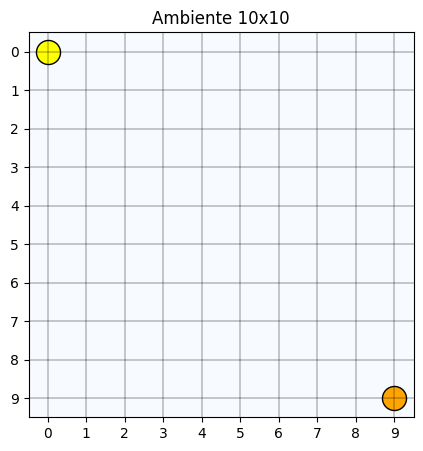

Tempo médio treino: 0.24404397010803222
Desvio padrão tempo: 0.005468893792929209


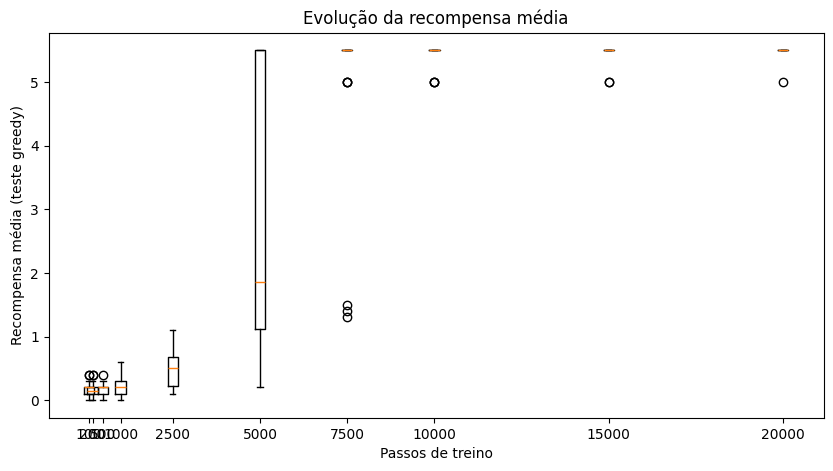

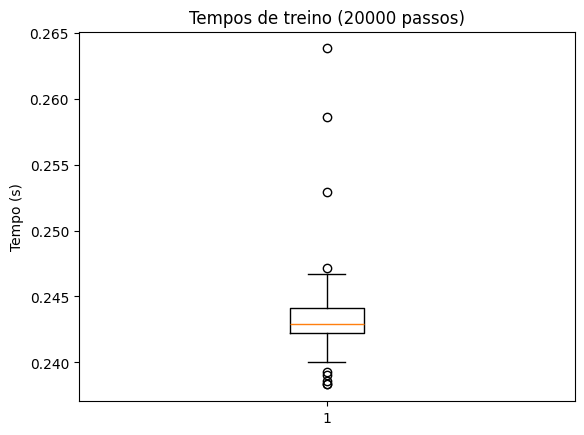

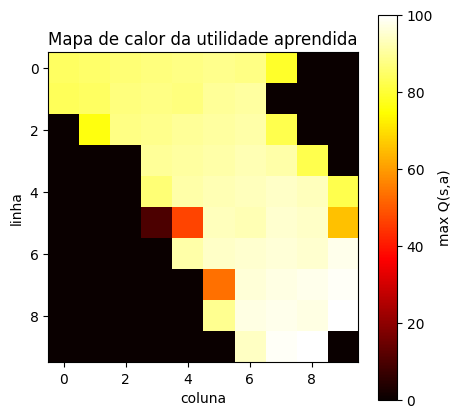

In [17]:
NUM_STATES = GRID_ROWS * GRID_COLS
NUM_ACTIONS = len(ACTIONS)

ALPHA = 0.7
GAMMA = 0.99

TEST_POINTS = [100, 200, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000]

def init_q():
    return np.zeros((NUM_STATES, NUM_ACTIONS))

def choose_action_eps_greedy(state, Q, greed):
    """greed = prob. de escolher a melhor ação; 1-greed = ação aleatória."""
    s_idx = state - 1

    # exploração
    if random.random() > greed:
        return random.randrange(NUM_ACTIONS)

    # exploração (melhor ação segundo Q)
    q_vals = Q[s_idx]
    max_q = np.max(q_vals)
    best = np.where(q_vals == max_q)[0]
    return random.choice(best)

def choose_action_greedy(state, Q):
    s_idx = state - 1
    q_vals = Q[s_idx]
    max_q = np.max(q_vals)
    best = np.where(q_vals == max_q)[0]
    return random.choice(best)

def q_update(Q, s, a_idx, r, s_next):
    s_idx = s - 1
    sn_idx = s_next - 1
    old = Q[s_idx, a_idx]
    best_next = np.max(Q[sn_idx])
    Q[s_idx, a_idx] = (1 - ALPHA) * old + ALPHA * (r + GAMMA * best_next)

def greedy_test(Q, n_steps=1000):
    """Teste: segue sempre a melhor ação; Q não muda."""
    state = START_STATE
    total_r = 0

    for _ in range(n_steps):
        a_idx = choose_action_greedy(state, Q)
        action = ACTIONS[a_idx]
        s_next = transition(state, action)
        r = reward(s_next)
        total_r += r

        if s_next == GOAL_STATE:
            state = START_STATE
        else:
            state = s_next

    return total_r / n_steps

def train_one_experiment(total_steps=20000, greed=0.9):
    """Treina Q-learning e faz testes nos pontos definidos."""
    Q = init_q()
    state = START_STATE
    steps_in_episode = 0

    test_results = {p: [] for p in TEST_POINTS}

    t0 = time.time()

    for step in range(1, total_steps + 1):
        a_idx = choose_action_eps_greedy(state, Q, greed)
        action = ACTIONS[a_idx]

        s_next = transition(state, action)
        r = reward(s_next)

        q_update(Q, state, a_idx, r, s_next)

        steps_in_episode += 1
        if s_next == GOAL_STATE or steps_in_episode >= 1000:
            state = START_STATE
            steps_in_episode = 0
        else:
            state = s_next

        if step in TEST_POINTS:
            m = greedy_test(Q)
            test_results[step].append(m)

    t1 = time.time()
    train_time = t1 - t0

    return Q, test_results, train_time

def run_many_experiments(num_exp=30, greed=0.9):
    all_tests = {p: [] for p in TEST_POINTS}
    times = []
    final_Q = None

    for _ in range(num_exp):
        Q, tests, t = train_one_experiment(greed=greed)
        times.append(t)
        final_Q = Q
        for p in TEST_POINTS:
            all_tests[p].extend(tests[p])

    return all_tests, times, final_Q

# -------- Visualizações --------

def draw_environment():
    grid = np.zeros((GRID_ROWS, GRID_COLS))
    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap="Blues", origin="upper")

    sr, sc = state_to_coords(START_STATE)
    plt.scatter(sc, sr, c="yellow", s=300, edgecolors="black")
    gr, gc = state_to_coords(GOAL_STATE)
    plt.scatter(gc, gr, c="orange", s=300, edgecolors="black")

    plt.xticks(range(GRID_COLS))
    plt.yticks(range(GRID_ROWS))
    plt.grid(True, color="black", linewidth=0.3)
    plt.title("Ambiente 10x10")
    plt.show()

def plot_learning_boxplots(all_tests):
    steps = sorted(TEST_POINTS)
    data = [all_tests[p] for p in steps]

    plt.figure(figsize=(10, 5))
    plt.boxplot(data, positions=steps, widths=300)
    plt.xlabel("Passos de treino")
    plt.ylabel("Recompensa média (teste greedy)")
    plt.title("Evolução da recompensa média")
    plt.show()

def plot_time_boxplot(times):
    plt.figure()
    plt.boxplot(times)
    plt.title("Tempos de treino (20000 passos)")
    plt.ylabel("Tempo (s)")
    plt.show()

def plot_heatmap_Q(Q):
    v = np.max(Q, axis=1)
    grid = v.reshape((GRID_ROWS, GRID_COLS))
    plt.figure(figsize=(5, 5))
    plt.imshow(grid, origin="upper", cmap="hot")
    plt.colorbar(label="max Q(s,a)")
    plt.title("Mapa de calor da utilidade aprendida")
    plt.xlabel("coluna")
    plt.ylabel("linha")
    plt.show()

# -------- Main --------

if __name__ == "__main__":
    random.seed(10)
    np.random.seed(10)

    draw_environment()

    # escolhe aqui o cenário:
    # greed = 0.0  -> ex2a (random walk)
    # greed = 1.0  -> ex2b (sempre greedy)
    # 0<greed<1    -> ex3 (mistura)
    greed_value = 0.9

    all_tests, times, Q_final = run_many_experiments(num_exp=30, greed=greed_value)

    print("Tempo médio treino:", np.mean(times))
    print("Desvio padrão tempo:", np.std(times))

    plot_learning_boxplots(all_tests)
    plot_time_boxplot(times)
    plot_heatmap_Q(Q_final)